### Final

In [19]:
import numpy as np
import pandas as pd
from sklearn import linear_model as skl_lm
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score


np.random.seed(1)

# Load the data from a CSV file
df = pd.read_csv("train.csv")

# Create a Stratified K-Fold object with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Create a logistic regression model
model = skl_lm.LogisticRegression(solver="liblinear")

# Define the range of values for the C parameter to be searched
param_grid = {"C": [0.001, .009, 0.01, .09, 1, 5, 10, 25], "penalty": ["l1", "l2"]}

# Define the grid search with 10-fold cross validation and the defined parameter grid
grid_search = GridSearchCV(model, param_grid, cv=skf, scoring="balanced_accuracy")

X = df.drop(columns=["Lead", "Total words"])
y = df["Lead"]

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameter and score found by the grid search
print("Best parameter found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best estimator found by the grid searchs
best_model = grid_search.best_estimator_

conf_matrices = []
recall_scores = []
precision_scores = []
f1_scores = []

# Loop through each fold of the Stratified K-Fold object
for fold, (train_index, test_index) in enumerate(skf.split(df, df["Lead"])):
    # Split the data into training and testing sets for the current fold
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    X_train = train.drop(columns=["Lead", "Total words"])
    Y_train = train["Lead"]
    X_test = test.drop(columns=["Lead", "Total words"])
    Y_test = test["Lead"]

    best_model.fit(X_train, Y_train)

    # Generate predicted probabilities 
    predict_prob = best_model.predict_proba(X_test)
    prediction = np.empty(len(X_test), dtype=object)
    prediction = np.where(predict_prob[:, 0] >= 0.345, best_model.classes_[0], best_model.classes_[1])

    # Generate a confusion matrix
    conf_matrix = pd.crosstab(prediction, Y_test)
    conf_matrix.reset_index(inplace=True)
    conf_matrix = conf_matrix.drop(columns="row_0")
    conf_matrix.index = ["Female", "Male"]

    conf_matrices.append(conf_matrix)
    precision_scores.append(precision_score(Y_test, prediction, pos_label="Female"))
    recall_scores.append(recall_score(Y_test, prediction, pos_label="Female"))
    f1_scores.append(f1_score(Y_test, prediction, pos_label="Female"))


avg_conf_matrix = sum(conf_matrices) / len(conf_matrices)


# Print the average confusion matrix
print("Average confusion matrix:")
print(avg_conf_matrix, "\n")

# Define a list of metrics to calculate
metrics = ["accuracy", "balanced_accuracy"]

X = df.drop(columns=["Lead", "Total words"])
y = df["Lead"]


# Loop through each metric and calculate the average score across all folds
for metric in metrics:
  scores = cross_val_score(best_model, X, y, cv=skf, scoring=metric)
  mean_score = np.mean(scores)
  print(f"Average {metric}: {mean_score:.3f}")
  
  test_df = pd.read_csv("test.csv")
  
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1_score = sum(f1_scores) / len(f1_scores)

print(f"Average precision: {avg_precision:.3f}")
print(f"Average recall: {avg_recall:.3f}")
print(f"Average F1 score: {avg_f1_score:.3f}")
####! PRINT THE TEST DATA ####
# Drop the "Lead" column from the test data
# X_test = test_df.drop(columns=["Lead",  "Total words"])

# # Generate predictions for the test data using the best model
# predictions = best_model.predict(X_test)

# # Save the predictions to a new Pandas DataFrame
# predictions_df = pd.DataFrame(predictions, columns=["Lead_prediction"])
# # Save the predictions to a CSV file
# # Concatenate the predictions into a single string separated by ","
# predictions_str = ",".join(predictions_df["Lead_prediction"].astype(str))
# predictions_str = predictions_str.replace("Male", "0").replace("Female", "1")
# # print(predictions_str)
# # Save the predictions as a CSV file
# with open("predictions1.csv", "w") as f:
#f.write(predictions_str)



Best parameter found:  {'C': 1, 'penalty': 'l1'}
Best score found:  0.7933592989289193
Average confusion matrix:
Lead    Female  Male
Female    18.5   8.5
Male       6.9  70.0 

Average accuracy: 0.877
Average balanced_accuracy: 0.793
Average precision: 0.689
Average recall: 0.728
Average F1 score: 0.704


### R optimized


Best parameter found:  {'C': 1, 'penalty': 'l1'}
Best score found:  0.7933592989289193
Average confusion matrix:
Lead    Female  Male
Female    18.0   5.8
Male       7.4  72.7 

Average accuracy: 0.873
Average balanced accuracy: 0.817


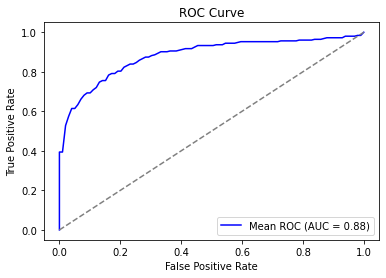

In [20]:
import numpy as np
from numpy import interp
import pandas as pd
from sklearn import linear_model as skl_lm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

np.random.seed(1)

# Load the data from a CSV file
df = pd.read_csv("train.csv")

# Create a Stratified K-Fold object with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Create a logistic regression model
model = skl_lm.LogisticRegression(solver="liblinear")

# Define the range of values for the C parameter to be searched
param_grid = {"C": [0.001, .009, 0.01, .09, 1, 5, 10, 25], "penalty": ["l1", "l2"]}

# Define the grid search with 10-fold cross validation and the defined parameter grid
grid_search = GridSearchCV(model, param_grid, cv=skf, scoring="balanced_accuracy")

X = df.drop(columns=["Lead", "Total words"])
y = df["Lead"]

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameter and score found by the grid search
print("Best parameter found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best estimator found by the grid searchs
best_model = grid_search.best_estimator_

conf_matrices = []
accuracies = []
balanced_accuracies = []
f1_scores = []
fpr = []
tpr = []
roc_auc = []
recall_scores = []
precision_scores = []
f1_scores = []


# Loop through each fold of the Stratified K-Fold object
for fold, (train_index, test_index) in enumerate(skf.split(df, df["Lead"])):
    # Split the data into training and testing sets for the current fold
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    X_train = train.drop(columns=["Lead", "Total words"])
    Y_train = train["Lead"]
    X_test = test.drop(columns=["Lead", "Total words"])
    Y_test = test["Lead"]

    best_model.fit(X_train, Y_train)


    predict_prob = best_model.predict_proba(X_test)
    # Create an array of thresholds to search through
    thresholds = np.arange(0.1, 1.0, 0.005)
    f1_scores = []
    # Loop through each threshold and calculate the F1 score
    for threshold in thresholds:
        prediction = np.where(predict_prob[:, 0] >= threshold, best_model.classes_[0], best_model.classes_[1])
        f1_scores.append(f1_score(Y_test, prediction, pos_label=best_model.classes_[0]))
    # Find the index of the threshold with the highest F1 score
    best_threshold_index = np.argmax(f1_scores)
    # Use the threshold with the highest F1 score to generate the final predictions
    prediction = np.where(predict_prob[:, 0] >= thresholds[best_threshold_index], best_model.classes_[0], best_model.classes_[1])
    
    fpr_, tpr_, thresholds = roc_curve(Y_test, predict_prob[:, 0], pos_label=best_model.classes_[0])
    fpr.append(fpr_)
    tpr.append(tpr_)
    roc_auc.append(auc(fpr_, tpr_))
    
    # print(f'Optimal threshold: {thresholds[best_threshold_index]:.3f}')
    # print('Accuracy:', np.mean(prediction == Y_test))
    # print(f'Balanced accuracy: {balanced_accuracy_score(Y_test, prediction):.3f}')

    # Generate a confusion matrix
    conf_matrix = pd.crosstab(prediction, Y_test)
    conf_matrix.reset_index(inplace=True)
    conf_matrix = conf_matrix.drop(columns="row_0")
    conf_matrix.index = ["Female", "Male"]

    conf_matrices.append(conf_matrix)
    accuracies.append(np.mean(prediction == Y_test))
    balanced_accuracies.append(balanced_accuracy_score(Y_test, prediction))
    precision_scores.append(precision_score(Y_test, prediction, pos_label="Female"))
    recall_scores.append(recall_score(Y_test, prediction, pos_label="Female"))
    f1_scores.append(f1_score(Y_test, prediction, pos_label="Female"))

avg_conf_matrix = sum(conf_matrices) / len(conf_matrices)
avg_accuracy = sum(accuracies) / len(accuracies)
avg_balanced_accuracy = sum(balanced_accuracies) / len(balanced_accuracies)

# Print the average confusion matrix
print("Average confusion matrix:")
print(avg_conf_matrix, "\n")
print(f"Average accuracy: {avg_accuracy:.3f}")
print(f"Average balanced accuracy: {avg_balanced_accuracy:.3f}")

# avg_precision = sum(precision_scores) / len(precision_scores)
# avg_recall = sum(recall_scores) / len(recall_scores)
# avg_f1_score = sum(f1_scores) / len(f1_scores)

# print(f"Average precision: {avg_precision:.3f}")
# print(f"Average recall: {avg_recall:.3f}")
# print(f"Average F1 score: {avg_f1_score:.3f}")

# Compute the mean FPR and TPR
min_fpr = np.max([fpr[i][0] for i in range(len(fpr))])
mean_fpr = np.linspace(min_fpr, 1, 100)
tprs = []
# Interpolate missing values because of different sizes 
for i in range(len(tpr)):
    tprs.append(interp(mean_fpr, fpr[i], tpr[i]))

# Compute the mean ROC AUC
mean_tpr = np.mean(tprs, axis=0)

mean_tpr = np.insert(mean_tpr, 0, 0.0)
mean_fpr = np.insert(mean_fpr, 0, 0.0)
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot the ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = %0.2f)' % mean_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Best parameter found:  {'C': 5, 'penalty': 'l2'}
Best score found:  0.7882565284178187
Average confusion matrix:
Lead    Female  Male
Female    17.9   5.7
Male       7.5  72.8 

Average accuracy: 0.873
Average balanced accuracy: 0.816
Average precision: 0.796
Average recall: 0.705
Average F1 score: 0.619


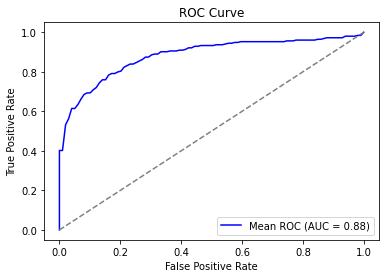

In [21]:
import numpy as np
from numpy import interp
import pandas as pd
from sklearn import linear_model as skl_lm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, auc,precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(1)

# Load the data from a CSV file
df = pd.read_csv("train.csv")

# Create a Stratified K-Fold object with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Split for grid search optimization
train, test = train_test_split(df, test_size=0.2, stratify=df["Lead"], random_state=1)

# Create a logistic regression model
model = skl_lm.LogisticRegression(solver="liblinear")

# Define the range of values for the C parameter to be searched
param_grid = {"C": [0.001, .009, 0.01, .09, 1, 5, 10, 25], "penalty": ["l1", "l2"]}

# Define the grid search with 10-fold cross validation and the defined parameter grid
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(model, param_grid, cv=skf, scoring="balanced_accuracy")

X_train = train.drop(columns=["Lead", "Total words"])
y_train = train["Lead"]

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameter and score found by the grid search
print("Best parameter found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best estimator found by the grid searchs
best_model = grid_search.best_estimator_

conf_matrices = []
accuracies = []
balanced_accuracies = []
f1_scores = []
fpr = []
tpr = []
roc_auc = []
recall_scores = []
precision_scores = []
f1_scores = []


# Loop through each fold of the Stratified K-Fold object
for fold, (train_index, test_index) in enumerate(skf.split(df, df["Lead"])):
    # Split the data into training and testing sets for the current fold
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    X_train = train.drop(columns=["Lead", "Total words"])
    Y_train = train["Lead"]
    X_test = test.drop(columns=["Lead", "Total words"])
    Y_test = test["Lead"]

    best_model.fit(X_train, Y_train)


    predict_prob = best_model.predict_proba(X_test)
    # Create an array of thresholds to search through
    thresholds = np.arange(0.1, 1.0, 0.005)
    f1_scores = []
    # Loop through each threshold and calculate the F1 score
    for threshold in thresholds:
        prediction = np.where(predict_prob[:, 0] >= threshold, best_model.classes_[0], best_model.classes_[1])
        f1_scores.append(f1_score(Y_test, prediction, pos_label=best_model.classes_[0]))
    # Find the index of the threshold with the highest F1 score
    best_threshold_index = np.argmax(f1_scores)
    # Use the threshold with the highest F1 score to generate the final predictions
    prediction = np.where(predict_prob[:, 0] >= thresholds[best_threshold_index], best_model.classes_[0], best_model.classes_[1])
    
    fpr_, tpr_, thresholds = roc_curve(Y_test, predict_prob[:, 0], pos_label=best_model.classes_[0])
    fpr.append(fpr_)
    tpr.append(tpr_)
    roc_auc.append(auc(fpr_, tpr_))
    
    # print(f'Optimal threshold: {thresholds[best_threshold_index]:.3f}')
    # print('Accuracy:', np.mean(prediction == Y_test))
    # print(f'Balanced accuracy: {balanced_accuracy_score(Y_test, prediction):.3f}')

    # Generate a confusion matrix
    conf_matrix = pd.crosstab(prediction, Y_test)
    conf_matrix.reset_index(inplace=True)
    conf_matrix = conf_matrix.drop(columns="row_0")
    conf_matrix.index = ["Female", "Male"]

    conf_matrices.append(conf_matrix)
    accuracies.append(np.mean(prediction == Y_test))
    balanced_accuracies.append(balanced_accuracy_score(Y_test, prediction))
    precision_scores.append(precision_score(Y_test, prediction, pos_label="Female"))
    recall_scores.append(recall_score(Y_test, prediction, pos_label="Female"))
    f1_scores.append(f1_score(Y_test, prediction, pos_label="Female"))

avg_conf_matrix = sum(conf_matrices) / len(conf_matrices)
avg_accuracy = sum(accuracies) / len(accuracies)
avg_balanced_accuracy = sum(balanced_accuracies) / len(balanced_accuracies)

# Print the average confusion matrix
print("Average confusion matrix:")
print(avg_conf_matrix, "\n")
print(f"Average accuracy: {avg_accuracy:.3f}")
print(f"Average balanced accuracy: {avg_balanced_accuracy:.3f}")

avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1_score = sum(f1_scores) / len(f1_scores)

print(f"Average precision: {avg_precision:.3f}")
print(f"Average recall: {avg_recall:.3f}")
print(f"Average F1 score: {avg_f1_score:.3f}")

# Compute the mean FPR and TPR
min_fpr = np.max([fpr[i][0] for i in range(len(fpr))])
mean_fpr = np.linspace(min_fpr, 1, 100)
tprs = []
# Interpolate missing values because of different sizes, don't know why
for i in range(len(tpr)):
    tprs.append(interp(mean_fpr, fpr[i], tpr[i]))

# Compute the mean ROC AUC
mean_tpr = np.mean(tprs, axis=0)

mean_tpr = np.insert(mean_tpr, 0, 0.0)
mean_fpr = np.insert(mean_fpr, 0, 0.0)
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot the ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = %0.2f)' % mean_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Load the test data from a CSV file
test_df = pd.read_csv("test.csv")

# Drop the "Lead" column from the test data
X_test = test_df.drop(columns=["Lead"])

# Generate predictions for the test data using the best model
predictions = best_model.predict(X_test)

# Save the predictions to a new Pandas DataFrame
predictions_df = pd.DataFrame(predictions, columns=["Lead_prediction"])
# Save the predictions to a CSV file
predictions_str = ",".join(predictions_df["Lead_prediction"].astype(str))
predictions_str = predictions_str.replace("Male", "0").replace("Female", "1")
# print(predictions_str)
# Save the predictions as a CSV file
with open("predictions.csv", "w") as f:
    f.write(predictions_str)

# print(predictions_df)

c:\Users\Dena Azarang\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Total words
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 13 features, but LogisticRegression is expecting 12 features as input.

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model as skl_lm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split


np.random.seed(1)

# Load the data from a CSV file
df = pd.read_csv("train.csv")

# Split the data into 80/20 train and test sets
train, test = train_test_split(df, test_size=0.2, stratify=df["Lead"], random_state=1)

# Create a logistic regression model
model = skl_lm.LogisticRegression(solver="liblinear")

# Define the range of values for the C parameter to be searched
param_grid = {"C": [0.001, .009, 0.01, .09, 1, 5, 10, 25], "penalty": ["l1", "l2"]}

# Define the grid search with 10-fold cross validation and the defined parameter grid
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(model, param_grid, cv=skf, scoring="balanced_accuracy")

X_train = train.drop(columns=["Lead", "Total words"])
y_train = train["Lead"]

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameter and score found by the grid search
print("Best parameter found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best estimator found by the grid search
best_model = grid_search.best_estimator_

X_test = test.drop(columns=["Lead", "Total words"])
y_test = test["Lead"]

best_model.fit(X_train, y_train)

# Generate predicted probabilities 
predict_prob = best_model.predict_proba(X_test)
prediction = np.empty(len(X_test), dtype=object)
prediction = np.where(predict_prob[:, 0] >= 0.5, best_model.classes_[0], best_model.classes_[1])

# Generate a confusion matrix
conf_matrix = pd.crosstab(prediction, y_test)
conf_matrix.reset_index(inplace=True)
conf_matrix = conf_matrix.drop(columns="row_0")
conf_matrix.index = ["Female", "Male"]

# Print the confusion matrix
print("Confusion matrix:")
print(conf_matrix, "\n")

# Calculate accuracy and balanced accuracy
accuracy = best_model.score(X_test, y_test)
balanced_accuracy = balanced_accuracy_score(y_test, prediction)

print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced Accuracy: {balanced_accuracy:.3f}")


Best parameter found:  {'C': 5, 'penalty': 'l2'}
Best score found:  0.7882565284178187
Confusion matrix:
Lead    Female  Male
Female      33    13
Male        18   144 

Accuracy: 0.851
Balanced Accuracy: 0.782
